In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import operator
from functools import reduce




def compl_mul2d(a, b):
    # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
    return torch.einsum("bixy,ioxy->boxy", a, b)

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def forward(self, x, size=None):
        if size==None:
            size = x.size(-1)

        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[2,3], norm="ortho")

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, size, size//2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)


        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(size, size), dim=[2,3], norm="ortho")
        return x

class SimpleBlock2d(nn.Module):
    def __init__(self, in_dim, out_dim, domain_size, modes1, modes2, width): # assumes square domain
        super(SimpleBlock2d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2

        self.width_list = [width*2//4, width*3//4, width*4//4, width*4//4, width*5//4]
        self.size_list = [domain_size] * 5
        self.grid_dim = 2

        self.fc0 = nn.Linear(in_dim+self.grid_dim, self.width_list[0])

        self.conv0 = SpectralConv2d(self.width_list[0], self.width_list[1], self.modes1*4//4, self.modes2*4//4)
        self.conv1 = SpectralConv2d(self.width_list[1], self.width_list[2], self.modes1*3//4, self.modes2*3//4)
        self.conv2 = SpectralConv2d(self.width_list[2], self.width_list[3], self.modes1*2//4, self.modes2*2//4)
        self.conv3 = SpectralConv2d(self.width_list[3], self.width_list[4], self.modes1*2//4, self.modes2*2//4)
        self.w0 = nn.Conv1d(self.width_list[0], self.width_list[1], 1)
        self.w1 = nn.Conv1d(self.width_list[1], self.width_list[2], 1)
        self.w2 = nn.Conv1d(self.width_list[2], self.width_list[3], 1)
        self.w3 = nn.Conv1d(self.width_list[3], self.width_list[4], 1)

        self.fc1 = nn.Linear(self.width_list[4], self.width_list[4]*2)
        self.fc2 = nn.Linear(self.width_list[4]*2, self.width_list[4]*2)
        self.fc3 = nn.Linear(self.width_list[4]*2, out_dim)

    def forward(self, x):

        batchsize = x.shape[0]
        size_x, size_y= x.shape[1], x.shape[2]
        grid = self.get_grid(size_x, batchsize, x.device)
        size_list = self.size_list

        x = torch.cat((x, grid.permute(0, 2, 3, 1)), dim=-1)

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x, size_list[1])
        x2 = self.w0(x.view(batchsize, self.width_list[0], size_list[0]**2)).view(batchsize, self.width_list[1], size_list[0], size_list[0])
        # x2 = F.interpolate(x2, size=size_list[1], mode='trilinear')
        x = x1 + x2
        x = F.selu(x) 

        x1 = self.conv1(x, size_list[2])
        x2 = self.w1(x.view(batchsize, self.width_list[1], size_list[1]**2)).view(batchsize, self.width_list[2], size_list[1], size_list[1])
        # x2 = F.interpolate(x2, size=size_list[2], mode='trilinear')
        x = x1 + x2
        x = F.selu(x) 

        x1 = self.conv2(x, size_list[3])
        x2 = self.w2(x.view(batchsize, self.width_list[2], size_list[2]**2)).view(batchsize, self.width_list[3], size_list[2], size_list[2])
        # x2 = F.interpolate(x2, size=size_list[3], mode='trilinear')
        x = x1 + x2
        x = F.selu(x)

        x1 = self.conv3(x, size_list[4])
        x2 = self.w3(x.view(batchsize, self.width_list[3], size_list[3]**2)).view(batchsize, self.width_list[4], size_list[3], size_list[3])
        # x2 = F.interpolate(x2, size=size_list[4], mode='trilinear')
        x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.selu(x)
        x = self.fc2(x)
        x = F.selu(x)
        x = self.fc3(x)
        return x

    def get_grid(self, S, batchsize, device):
        gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
        gridx = gridx.reshape(1, 1, S, 1).repeat([batchsize, 1, 1, S])
        gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, S).repeat([batchsize, 1, S, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)

class Net2d(nn.Module):
    def __init__(self, in_dim, out_dim, domain_size, modes, width):
        super(Net2d, self).__init__()
        self.conv1 = SimpleBlock2d(in_dim, out_dim, domain_size, modes, modes, width)

    def forward(self, x):
        x = self.conv1(x)
        return x

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

In [3]:
net = Net2d(in_dim=1, out_dim=2, domain_size=64, modes=16, width=64)
input_tensor = torch.randn(15, 64, 64,1)  # 假设这是你的输入数据
output = net(input_tensor)


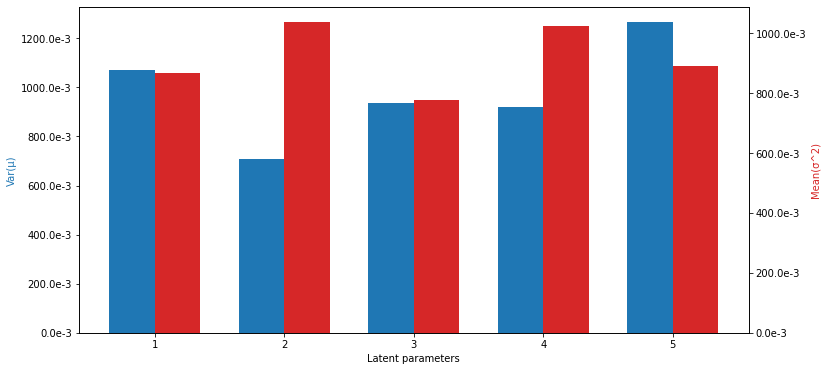

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.ticker import FuncFormatter

# 定义一个格式化函数，这里以1e-3为例
def scientific_formatter(x, pos):
    return f'{x*1e3:.1f}e-3'  # 转换为1e-3为单位的表示，你可以根据需要调整格式

# 假设有一些数据
mu_data = torch.randn(100, 5)  # 示例数据
logvar = torch.randn(100, 5)  # 示例数据

# 下面是绘图的函数
latent_numbers = mu_data.shape[-1]
mu_mean = torch.mean(mu_data, dim=0).cpu().detach().numpy()
mu_variances = mu_data.var(dim=0, unbiased=False).cpu().detach().numpy()
logvar_mean = logvar.mean(dim=0).cpu().detach().numpy()

x = np.arange(latent_numbers)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width/2, mu_variances, width, label='Var of mean', color='tab:blue')
ax2 = ax.twinx()
rects2 = ax2.bar(x + width/2, np.exp(logvar_mean), width, label='Mean of var', color='tab:red')

# 应用自定义格式化器
formatter = FuncFormatter(scientific_formatter)
ax.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

# 其余的绘图设置
ax.set_xlabel('Latent parameters')
ax.set_ylabel('Var(µ)', color='tab:blue')
ax2.set_ylabel('Mean(σ^2)', color='tab:red')
ax.set_xticks(x)
ax.set_xticklabels(['1', '2', '3', '4', '5'])
